In [14]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

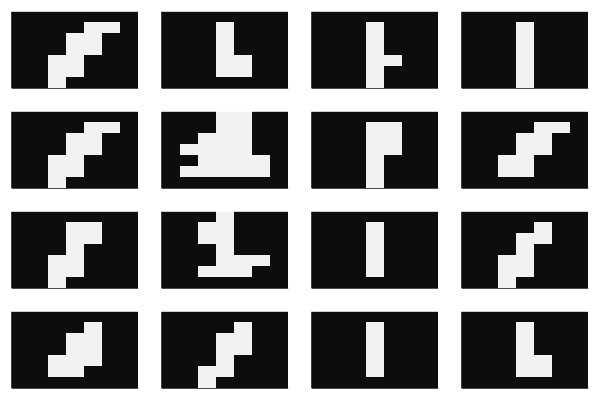

In [15]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 7 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [16]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

#Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 
# Use CNN (because it's currently very bad at distinguishing images)
# Writing a discriminator in Pytorch is better?

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) #Implemented using qiskit's definition (https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html)
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    # for i in 1:N-1
    #     push!(g, rot(kron(N, i => Y, i+1 => Y), 0.))
    # end
    # Not needed YY = XX and IZ and ZI
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end
#To enhance expressibility:
# Change circuit ansatz to include more generators
# Change pprior() to become nonconstant
# Gradient doesn't change if you sample from a nonconstant distribution of states? As opposed to all zero state
# Can prove this analytically
# Run on GPU?

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, :random)
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 511
Number of parameters in generator: 725
[2.8203825946344745, 3.121058391834169, 5.403740552810762, 2.828367644651389, 6.065499623560687, 2.9697473546221294, 6.186841803592731, 4.13579453427007, 3.62158962681127, 4.525599344044992, 5.480866816168105, 1.3800084156098253, 4.194956875949634, 3.5731302672296588, 0.010232384597492853, 0.8869068658626983, 2.3142681074751414, 5.755703054747708, 4.521966278373602, 2.8258803978597986, 3.176833697111454, 2.6176987783101855, 5.708462260119803, 1.9123895633147119, 2.4438001572903705, 5.417427237989525, 4.551940734508952, 2.3754516076693912, 5.396049555478187, 0.6469416505577286, 2.3169989984098813, 1.4277099976274734, 3.989704866383899, 0.1699331657066575, 1.1499606267490403, 4.446899991339046, 2.147424881450622, 5.856001519845358, 1.2537042245490004, 0.9422458277330857, 2.1576325666163765, 3.7574279427626163, 3.98854672889372, 1.4568464248022788, 0.8759999262963759, 3.90178120224681, 1.208152672307492, 5.9

, 4.897303971391026, 2.1658683152660245, 5.0513370258175385, 5.158212543950305, 5.8899602753910685, 5.00273053640164, 2.132551861294352, 5.34839800518532, 0.0754570851512924, 5.04569225883276, 0.11958899441992059, 3.098779375081117, 6.2497250078973705, 6.070234595691237, 2.130050823383021, 2.2621928445246007, 1.3200197769631938, 3.3141728496748635, 2.850025221680874, 5.407055593435087, 2.330740551939371, 2.345814210724846, 6.169351050160598, 2.8265085504184477, 1.8898353305868734, 0.5824204812177887, 0.3307472147203152, 1.2039485072811433, 2.451654674103677, 3.357061410855976, 3.6449212791586425, 4.5012097522018, 3.334417774684279, 1.1046939916180585, 1.7176449442586896, 1.4173779847726942, 0.007745027110675255, 0.839972582641344, 5.64138233955338, 4.536689009145025, 3.736250062827202, 1.7626862842793323, 4.974675740963327, 0.8628629608431609, 0.43587905768894364,

 4.057243421301767, 2.0849496710537996, 0.4919988610090408, 0.2470854073041494, 1.4605938849846463, 6.153012240294533, 2.432791232838001, 3.3976870270675352, 3.008037450023589, 4.180470699669969, 3.190764758703871, 2.397243936028734, 4.860263132908956, 6.024927751455152, 2.416961780834547, 5.916872238285607, 6.118174063981746, 5.651330530743498, 3.4922764639230355, 0.8612723630769892, 4.337778615426225, 5.4984289058307105, 1.4896596966471671, 0.0686679723925314, 3.2829538745277915, 3.4121792425389166, 5.635416323706267, 0.032713023848518, 4.3311435091306505, 5.737928672896858, 0.8142639015800307, 4.903655238792061, 5.536301123320992, 5.647064368361291, 5.387892923987135, 4.126912581923717, 3.6041369108687853, 5.461379297796851, 1.9669869821032913, 4.133874572658536, 5.817904570086672, 0.9091921257499416, 1.4169735471952627, 2.2616994390570775, 5.7222890904913735, 1.1427799280824247, 0.4301159763336687, 5.31383321302031, 0.20636121398976817, 4.910953147900181, 5.443808215118793, 0.23563

μ: 9.25
σ: 3.5870136139505613
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

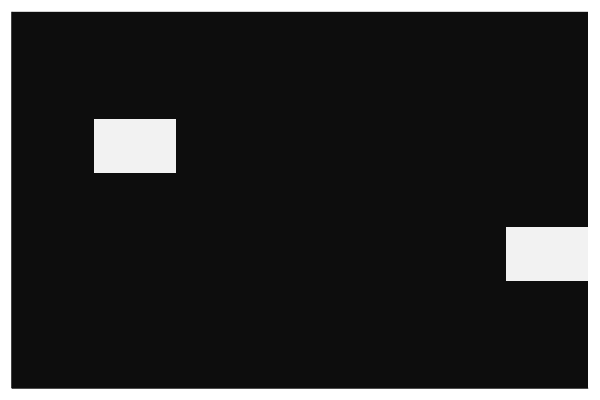

In [17]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 1/49 #if ratio = 0 then pprior() is all 0s
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [18]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 100 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result) #is this operation slow; on another note there has to be a better way to write this function right
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

#Ideally... but how do u get gradients to go down? do we just not use flux train? tbh i'm ok with that but then i need to figure out how else to implement optimization stuff (maybe use python)
# function dLoss(nbatch = samplemean_batch)
#     real = mean(log.(run_d_real()))
#     fake = mean(log.(1 .- run_d_fake(run_g(nbatch))))
#     -(real + fake)
# end

#This is only formatted like this in order to use Flux.train!
#So maybe I shouldn't use it?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.6452771f0

In [19]:
# using Plots
# using Statistics

# p = []
# for _ in 1:500
#     push!(p, gLoss())
# end

# histogram(p, bins=20, xlabel="gLoss", ylabel="Frequency")

# #@time gLoss() #It's still decently spread out...

In [20]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss() #This is the problem
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

#println(finitediff_grad())
#Computing gradients is slow and also I'm still getting different results for parametershift and finitediff
#parametershift prints very small numbers and finitediff prints very big numbers...

# for _ in 1:10
#     println(parametershift_grad()) #Should print similar numbers...
# end

parametershift_grad (generic function with 2 methods)

In [21]:
g_lr = 1 #Usually is like 10^{-3} to 10^{-4}
d_lr = 1e-3

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []
#Keep track of avg discriminator output on real vs. fake data and make sure none of them gets too small or too large
g_epochs = 10 #Dynamically change this during training?
d_epochs = 3
epochs = 30
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    d_fake = first(run_d_fake(run_g(nbatch = 1)))
    push!(dfake_vals, d_fake)
    index = rand(1:train)
    d_real = data_train[index] |> vec |> d |> first
    push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

#last g_epochs of training for the generator, because we want g to be good, don't really care about d
for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
end

iteration 1 done in: 1361.6085510253906
iteration 2 done in: 

1433.013867855072


iteration 3 done in: 11895.589920043945
iteration 4 done in: 

5690.3731808662415


iteration 5 done in: 10965.621099948883
iteration 6 done in: 

14067.79431605339


iteration 7 done in: 1541.2676289081573
iteration 8 done in: 

1515.1478309631348


iteration 9 done in: 8863.656267166138
iteration 10 done in: 

4744.769381046295


iteration 11 done in: 1366.5474979877472
iteration 12 done in: 

1322.399015903473


iteration 13 done in: 5706.411367893219
iteration 14 done in: 

6047.854719161987


iteration 15 done in: 1342.7483129501343
iteration 16 done in: 

1359.7777030467987


iteration 17 done in: 6001.8459649086
iteration 18 done in: 

4064.9447860717773


iteration 19 done in: 3517.358272075653
iteration 20 done in: 

7038.278572797775


iteration 21 done in: 13929.889976978302
iteration 22 done in: 

34361.388259887695


iteration 23 done in: 10972.714512825012
iteration 24 done in: 

40224.93259000778


iteration 25 done in: 38748.43847107887
iteration 26 done in: 

14324.299103975296


iteration 27 done in: 11092.707903862
iteration 28 done in: 

10934.017269134521


iteration 29 done in: 12462.362787008286
iteration 30 done in: 

39243.52945280075


Generator loss
Any[0.6322063f0, 0.5717055f0, 0.5684671f0, 0.5339349f0, 0.50033855f0, 0.4733612f0, 0.43895736f0, 0.4005545f0, 0.385091f0, 0.36077797f0, 0.73078537f0, 0.72488487f0, 0.6700724f0, 0.65059143f0, 0.64007384f0, 0.60825574f0, 0.58613825f0, 0.5555684f0, 0.5160297f0, 0.5119612f0, 0.9923107f0, 0.9209932f0, 0.8713141f0, 0.8658338f0, 0.8267963f0, 0.7964816f0, 0.76384073f0, 0.68647516f0, 0.729374f0, 0.69545436f0, 1.1566327f0, 1.1528559f0, 1.1485703f0, 1.0612292f0, 1.0491207f0, 1.0132365f0, 0.974522f0, 0.9513961f0, 0.93275934f0, 0.89546907f0, 1.2228031f0, 1.0797291f0, 1.0267395f0, 0.9555389f0, 0.9257399f0, 0.91047686f0, 0.9284193f0, 0.8127504f0, 0.75652725f0, 0.81821936f0, 1.0255855f0, 1.0106448f0, 0.9480496f0, 0.907472f0, 0.91489357f0, 0.8051985f0, 0.8091234f0, 0.7937661f0, 0.74569285f0, 0.71279997f0, 1.0443538f0, 1.0635968f0, 0.94529814f0, 0.93486905f0, 0.9913259f0, 0.90048486f0, 0.8957399f0, 0.8687674f0, 0.8165968f0, 0.7904377f0, 0.99792755f0, 0.9967926f0, 0.9878335f0, 0.9081249f0,

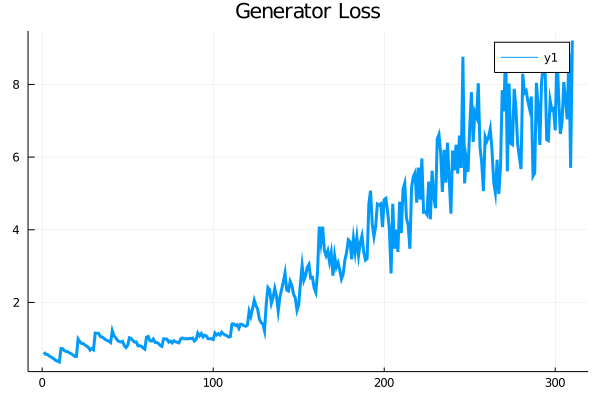

In [22]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.5634062f0, 1.478453f0, 1.2198402f0, 1.3940743f0, 1.086465f0, 0.98341984f0, 1.1231849f0, 0.9761477f0, 0.85957545f0, 0.99590105f0, 0.92221045f0, 0.8106321f0, 1.037888f0, 0.9354362f0, 0.8832504f0, 1.0354598f0, 1.0340977f0, 0.9546461f0, 1.0909917f0, 1.0332325f0, 0.9964967f0, 1.015094f0, 0.95124966f0, 0.93505853f0, 0.9192275f0, 0.9106451f0, 0.8111944f0, 0.85898733f0, 0.8042096f0, 0.8475218f0, 0.82559997f0, 0.79651725f0, 0.7388383f0, 0.71689373f0, 0.7174162f0, 0.6581936f0, 0.7250332f0, 0.59565663f0, 0.5723567f0, 0.5527803f0, 0.5017647f0, 0.39601496f0, 0.44966075f0, 0.5227316f0, 0.4278807f0, 0.5000123f0, 0.46095172f0, 0.46531272f0, 0.44680032f0, 0.3682957f0, 0.312931f0, 0.22503436f0, 0.23248081f0, 0.2086827f0, 0.31938356f0, 0.26027453f0, 0.20888148f0, 0.15558897f0, 0.16449328f0, 0.13646281f0, 0.30043536f0, 0.15205972f0, 0.22356948f0, 0.11349634f0, 0.10873299f0, 0.12851875f0, 0.14729895f0, 0.20277564f0, 0.20998344f0, 0.098220535f0, 0.100828126f0, 0.137005f0, 0.10871342

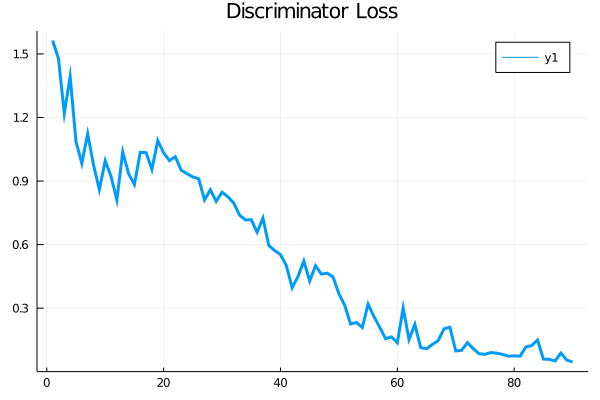

In [23]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients
Any[-8.181732276390339e-5, -0.0006857491361683813, -0.00043846681200224776, -0.00036751930055947137, -0.00043598335364769243, -0.00045023990088495714, 0.00011089113251916294, -3.610997364438813e-5, 0.0006827405197867032, 0.00013083363401478735, 0.00012935449337137157, 0.0004670534462764345, 0.000306744411073882, 0.0015475423993735477, -8.869828849003233e-5, -5.738652985671471e-6, 0.0006344377994537354, 0.00041473088593318546, 0.00032857282408352555, 0.0006380658930745618, 0.001083960615355393, 0.0004827843452322072, 0.0010351051544320994, 0.00021564553523885791, 0.0013714010139991497, 0.000598599622989523, 0.0009721055113036057, 0.001005214000570363, 0.0002687930238657984, -0.0008599309263558223, -0.00033329199100362843, -0.000818241546893942, 0.00010970082776299839, 9.459322896497002e-5, 0.0005041652712328681, -0.0001524974148848961, -0.00042988662062020137, -0.0008842819312523152, -0.0005588099463232632, -0.0007180989610737768, -0.001468016114728204, -0.000544697005173

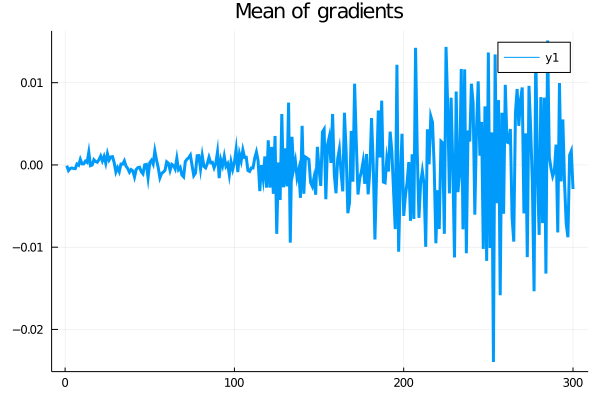

In [24]:
println("Mean gradients")

println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [25]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.0013534861
real data: 0.9883797


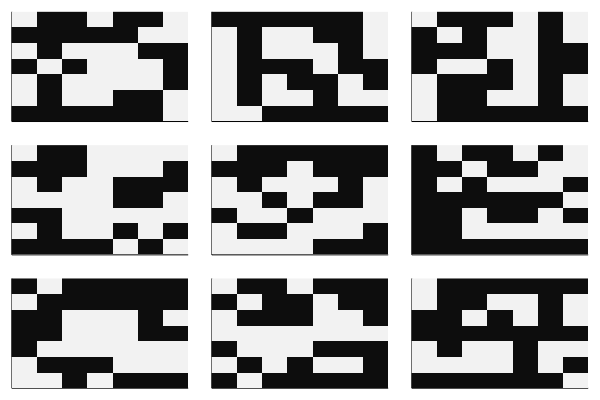

In [26]:
#Testing the Generator

nsamples = 9
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)